Librairies

In [55]:
import s3fs
from pathlib import Path
import py7zr
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

## Données Pleiades

- Ce sont des images de 2000x2000 pixels à 50 cm le pixel => 1000x1000 m^2 = 1km^2
- On en a 240 dans le fichier brut or la superficie de Cayenne est égale à 23,6 km^2
- 4 channels RGB Infra
- Le fichier pour Cayenne fait 2 GB

## Rasterio 
https://geohackweek.github.io/raster/04-workingwithrasters/

In [56]:
import rasterio
import rasterio.plot as rp
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from rasterio.crs import CRS
import matplotlib
from rasterio.features import rasterize

In [57]:
im_dir = "Cayenne_200722/16bits/ORT_2022072050325085_U22N/"
liste  = os.listdir(im_dir)
list_path_image = [im_dir+l for l in liste]

len(liste)

240

In [58]:
## Caractéristique d'une image
filepath = list_path_image[200] 
filepath = 'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
# 72 et 37 bons exemples
with rasterio.open(filepath) as raster:
    print(raster.profile)
    print(raster.overviews(1))
    
# En se servant du nom on peut faire des mosaiques en filtrant sur les chiffres

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 2000, 'height': 2000, 'count': 4, 'crs': CRS.from_epsg(2972), 'transform': Affine(0.5, 0.0, 353000.0,
       0.0, -0.5, 545000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}
[2, 4, 8, 16]


[2, 4, 8, 16]


Text(0, 0.5, 'Pixels Lignes')

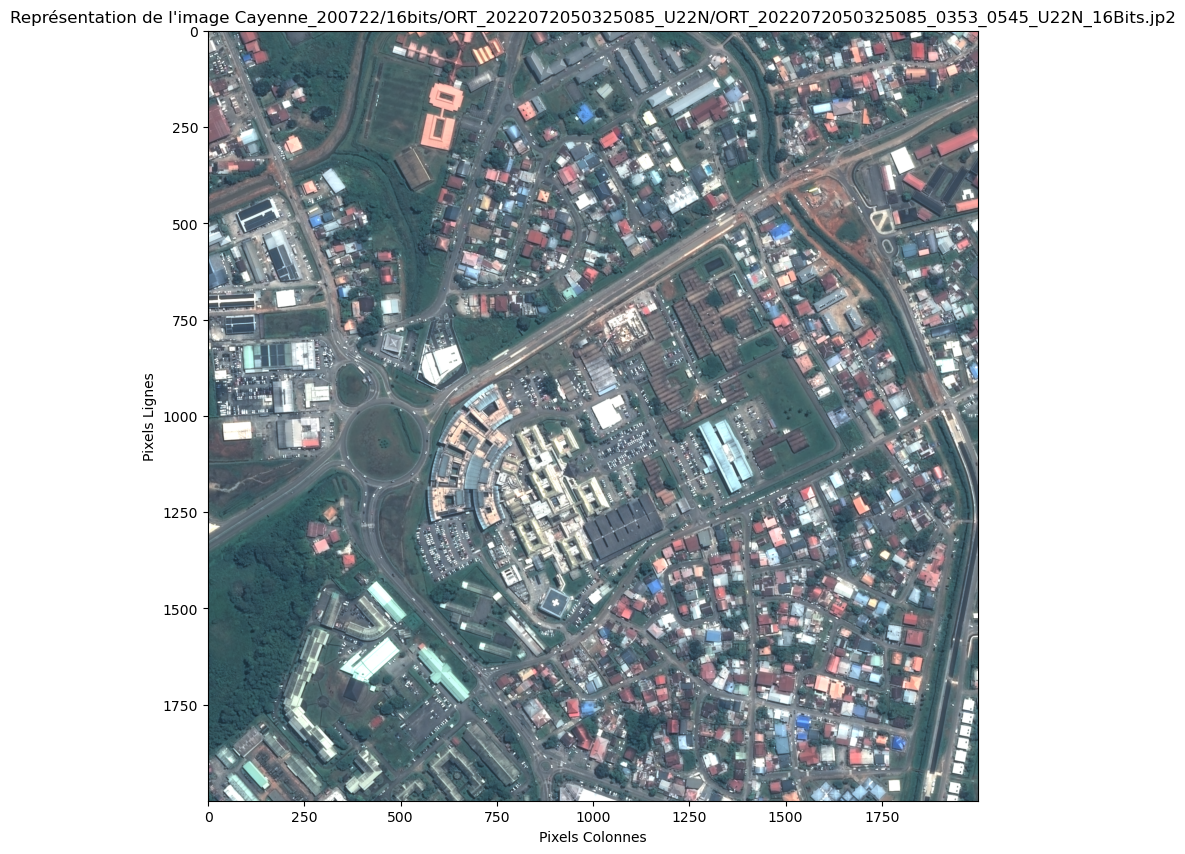

In [59]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as raster:
    oviews = raster.overviews(1) # list of overviews from biggest to smallest
    print(oviews)
    oview = 1 # let's look at the smallest thumbnail

    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    B1 = raster.read(1, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B2 = raster.read(2, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B3 = raster.read(3, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B4 = raster.read(4, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))

quantile = 0.97
B1a = rp.adjust_band(np.clip(B1,0,np.quantile(B1,quantile))) # normalisation min-max simple nécessite un clip d'abord étant donné les valeurs extremes
B2a = rp.adjust_band(np.clip(B2,0,np.quantile(B2,quantile)))
B3a = rp.adjust_band(np.clip(B3,0,np.quantile(B3,quantile)))
B4a = rp.adjust_band(np.clip(B4,0,np.quantile(B4,quantile)))

rgb = np.dstack((B1a,B2a,B3a))

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb)
plt.title("Représentation de l'image {}".format(filepath))
plt.xlabel('Pixels Colonnes')
plt.ylabel('Pixels Lignes')


### Passage le raster à la géométrie GPS

On peut transformer les données en GPS
On peut également avoir les limites géographique de l'image
cf ici : https://rasterio.readthedocs.io/en/latest/topics/reproject.html
On a peut-être meilleur temps de transformer les donénes RIL dans le bon EPSG mais pour la forme déjà

In [60]:
dst_crs = 'EPSG:4326'

with rasterio.open(filepath) as src:
    print(src.profile)
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    width = height = src.width # je contrains 
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open('tmp.tif', 'w', **kwargs) as dst: # écriture de la reprojection dans un tiff
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs
            )


{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 2000, 'height': 2000, 'count': 4, 'crs': CRS.from_epsg(2972), 'transform': Affine(0.5, 0.0, 353000.0,
       0.0, -0.5, 545000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}


In [61]:
rasterwgs84 = rasterio.open('tmp.tif')
rasterwgs84.bounds

BoundingBox(left=-52.32580589928141, bottom=4.920328778395846, right=-52.31677510776761, top=4.929359569909651)

## Récupération de la BDTOPO

In [68]:
import s3fs
import yaml

with open("../environment.yml", 'r') as stream:
    environment = yaml.safe_load(stream)
file_path = "projet-slums-detection/Donnees/BDTOPO/" + environment["sources"]["bdtopo"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get(file_path, "bdtopo.7z")
with py7zr.SevenZipFile('bdtopo.7z', mode='r') as z:
    z.extractall()

In [73]:
import geopandas as gpd

bdtopo_guyane  = gpd.read_file("BDTOPO_3-0_TOUSTHEMES_SHP_UTM22RGFG95_D973_2022-03-15/BDTOPO/1_DONNEES_LIVRAISON_2022-03-00081/BDT_3-0_SHP_UTM22RGFG95_D973-ED2022-03-15/BATI/BATIMENT.shp")
bdtopo_guyane.head()

,ID,NATURE,USAGE1,USAGE2,LEGER,ETAT,DATE_CREAT,DATE_MAJ,DATE_APP,DATE_CONF,...,MAT_MURS,MAT_TOITS,HAUTEUR,Z_MIN_SOL,Z_MIN_TOIT,Z_MAX_TOIT,Z_MAX_SOL,ORIGIN_BAT,APP_FF,geometry
0,BATIMENT0000002200075739,Indifférenciée,Indifférencié,None,Non,En service,2018-12-11 17:53:51,2019-03-15 18:34:53,None,None,...,None,None,NaN,NaN,None,None,None,Autre,None,"POLYGON Z ((356654.100 545172.100 -1000.000, 3..."
1,BATIMENT0000002200087667,Indifférenciée,Indifférencié,None,Non,En service,2018-12-12 17:21:53,2019-03-15 18:34:53,None,None,...,None,None,NaN,NaN,None,None,None,Imagerie aérienne,None,"POLYGON Z ((355460.300 545993.000 -1000.000, 3..."
2,BATIMENT0000002200158349,Indifférenciée,Indifférencié,None,Non,En service,2018-12-14 16:10:20,2019-03-15 18:34:53,None,None,...,None,None,NaN,NaN,None,None,None,Imagerie aérienne,None,"POLYGON Z ((354335.600 545373.700 -1000.000, 3..."
3,BATIMENT0000002200075740,Indifférenciée,Indifférencié,None,Non,En service,2018-12-11 17:53:51,2019-03-15 18:34:53,None,None,...,None,None,NaN,NaN,None,None,None,Autre,None,"POLYGON Z ((356669.300 545116.600 -1000.000, 3..."
4,BATIMENT0000002200158350,Indifférenciée,Indifférencié,None,Non,En service,2018-12-14 16:10:20,2019-03-15 18:34:53,None,None,...,None,None,NaN,NaN,None,None,None,Imagerie aérienne,None,"POLYGON Z ((354344.800 545397.600 -1000.000, 3..."


In [74]:
bdtopo_guyane.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 86708 entries, 0 to 86707
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          86708 non-null  object  
 1   NATURE      86708 non-null  object  
 2   USAGE1      86708 non-null  object  
 3   USAGE2      0 non-null      object  
 4   LEGER       86708 non-null  object  
 5   ETAT        86708 non-null  object  
 6   DATE_CREAT  86708 non-null  object  
 7   DATE_MAJ    30266 non-null  object  
 8   DATE_APP    0 non-null      object  
 9   DATE_CONF   33143 non-null  object  
 10  SOURCE      10466 non-null  object  
 11  ID_SOURCE   45 non-null     object  
 12  PREC_PLANI  86708 non-null  float64 
 13  PREC_ALTI   86708 non-null  float64 
 14  NB_LOGTS    0 non-null      object  
 15  NB_ETAGES   0 non-null      object  
 16  MAT_MURS    0 non-null      object  
 17  MAT_TOITS   0 non-null      object  
 18  HAUTEUR     86093 non-null  float64 
 

In [75]:
bdtopo_guyane.NATURE.unique()

array(['Indifférenciée', 'Industriel, agricole ou commercial', 'Serre',
       'Chapelle', 'Tour, donjon', 'Tribune', 'Eglise', 'Moulin à vent',
       'Silo', 'Fort, blockhaus, casemate', 'Monument'], dtype=object)

In [76]:
bdtopo_guyane.USAGE1.unique()

array(['Indifférencié', 'Sportif', 'Industriel', 'Commercial et services',
       'Agricole', 'Résidentiel', 'Religieux'], dtype=object)

In [81]:
bdtopo_guyane.SOURCE.unique()

array([None, 'MSS', 'RGG', 'MSS_2013', 'MSS_2018', 'CADASTRE/RGG'],
      dtype=object)

Ministère en charge de la Santé et des Sports, Référentiel Géographique Guyanais sont les sources principales

Colonnes qui nous intéressent :
- NATURE
- USAGE1
- DAT_CREAT
- DAT_MAJ
- SOURCE
- GEOMETRY

In [86]:
bdtopo_guyane.columns

Index(['ID', 'NATURE', 'USAGE1', 'USAGE2', 'LEGER', 'ETAT', 'DATE_CREAT',
       'DATE_MAJ', 'DATE_APP', 'DATE_CONF', 'SOURCE', 'ID_SOURCE',
       'PREC_PLANI', 'PREC_ALTI', 'NB_LOGTS', 'NB_ETAGES', 'MAT_MURS',
       'MAT_TOITS', 'HAUTEUR', 'Z_MIN_SOL', 'Z_MIN_TOIT', 'Z_MAX_TOIT',
       'Z_MAX_SOL', 'ORIGIN_BAT', 'APP_FF', 'geometry'],
      dtype='object')

In [85]:
bdtopo_guyane = bdtopo_guyane[["NATURE", "USAGE1", "DAT_CREAT", "DAT_MAJ", "SOURCE", "GEOMETRY"]]

KeyError: "['DAT_CREAT', 'DAT_MAJ', 'GEOMETRY'] not in index"

## Récupération du RIL

Maintenant on va vouloir se servir de la bounding box du raster.bounds pour récupérer les points RIL à l'intérieur de cette zone et voir ce que ça donne
On récupère également le Ril de Cayenne prétransformer au format geopackage (il ne reste plus que les coordonnées dedanss) et déjà projeter en corordonnées GPS


In [ ]:
#import s3fs
#fs = s3fs.S3FileSystem(#se connecter en allant dans connexion to storage etc.. dans onyxia)
fs.get('projet-slums-detection/Donnees/ril_cayenne.gpkg', 'ril_cayenne.gpkg')

Pour superposer points et rasters
https://stackoverflow.com/questions/57535504/how-to-plot-spatial-points-over-a-raster-layer-python

In [ ]:
ril_cayenne  = gpd.read_file("ril_cayenne.gpkg")

# on borne le gpd sur le patch
xmin, ymin, xmax, ymax = rasterwgs84.bounds
ril_patch = ril_cayenne.cx[xmin:xmax,ymin:ymax]

ril_patch

### Plus qu'à superposer !

In [ ]:
raster_extent = [rasterwgs84.bounds[0], rasterwgs84.bounds[2], rasterwgs84.bounds[1], rasterwgs84.bounds[3]]

fig, ax = plt.subplots(figsize=(10, 10))
show(
    np.moveaxis(climNormStack(rasterwgs84), -1, 0),
    extent = raster_extent,  # sans ce paramètre c'est infaisable.. cf https://stackoverflow.com/questions/61980063/python-how-to-place-a-shapefile-on-top-of-raster-file-in-one-plot-and-then-sa
    ax=ax
)

ril_patch.plot(color = "red",ax = ax)


## Rasteriszation des points

Ici je veux rasterizer les points pour produire le fameux masqure d'entrainement de même dimension que l'image
LE processus est facilement réalisable avec la foinctiion rasterize
https://pygis.io/docs/e_raster_rasterize.html

Au passage la bible sur geopandas :
https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.cx.html

In [ ]:
ril_patch.geometry

In [ ]:
rasterized = rasterize(ril_patch.geometry,
                                out_shape = rasterwgs84.shape,
                                fill = 0,
                                out = None,
                                transform = rasterwgs84.transform,
                                all_touched = True,
                                default_value = 1,
                                dtype = None)

# Plot raster
fig, ax = plt.subplots(1, figsize = (5, 5))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()


Evidemment on ne voit rien car on a- un. petit ensemble de points sur un carré de 2000 x 2000..

In [ ]:
rasterized.shape
print(sum(rasterized[rasterized !=0]))
print(len(ril_patch))

774 pixels passés à 1 dans le raster versus les 1483 points présents dans le patch, difficile de comprendre pour quoi
Il est certainement plus judicieux de faire des buffer autour des  points puis de rasterizer. (le gral ce serait la parcelle cadastrale à voir plus tard)

In [ ]:
ril_patch_polygon = ril_patch.copy()
ril_patch_polygon.geometry = ril_patch_polygon.geometry.to_crs(2972).buffer(6,cap_style=3).to_crs(4326) 
# buffer de 6 m cap style 3 pour carré
#ril_patch_polygon

In [ ]:
raster_extent = [rasterwgs84.bounds[0], rasterwgs84.bounds[2], rasterwgs84.bounds[1], rasterwgs84.bounds[3]]

red = rasterwgs84.read(1)
fig, ax = plt.subplots(figsize=(10, 10))
show(
    np.moveaxis(climNormStack(rasterwgs84), -1, 0),
    extent = raster_extent,  # sans ce paramètre c'est infaisable.. cf https://stackoverflow.com/questions/61980063/python-how-to-place-a-shapefile-on-top-of-raster-file-in-one-plot-and-then-sa
    ax=ax
)
ril_patch_polygon.plot(color = "red",ax = ax)


On retente la rasterization avec nos polygones 

In [ ]:
rasterized = rasterize(ril_patch_polygon.geometry,
                                out_shape = rasterwgs84.shape,
                                fill = 0,
                                out = None,
                                transform = rasterwgs84.transform,
                                all_touched = True,
                                default_value = 1,
                                dtype = None)

# Plot raster
fig, ax = plt.subplots(1, figsize = (5, 5))
show(rasterized, ax = ax)
plt.gca()
print(rasterized.shape)

Et voilà :)

## Découpage et fusion des images 

## Création d'une mosaique

En fait il est possible de réunir un ensemble d'images raster en une seule et grosse image (pas forcément raisonnable dans notre cas) Dans un premier temps on liste l'ensemble des fichiers jp2 de la mosaïque que l'on veut créer

On ne va pas metttre les 240 car c'est trop lour mais on peut récupérer une sous partie des fichiers en récupérant les affine transform de chaqsue raster

création d'un data frame avec les file paths et lex x min y min (surelment le coin en haut à gauche)
Pour pouvoir sé"lectionner une sous liste de file path qui convient

In [ ]:
list_x = []
list_y = []
for filepath in list_path_image:
    with rasterio.open(filepath) as raster:
        new_x = raster.profile['transform'][5]
        new_y = raster.profile['transform'][2]
        list_x.append(new_x)
        list_y.append(new_y)

In [ ]:
df = pd.DataFrame(list(zip(list_x,list_y,list_path_image)),
               columns =['x', 'y','path'])
df.sort_values(['y','x'])  # ok ça va de 1000. en 1000
print(min(df.x)) # 534000
print(min(df.y)) # 348000
print(max(df.x)) # 549000
max(df.y) # 362000


16*15 = 240 images Ok ! On sélectionne la tranche que l'on veut ?

In [ ]:
file_to_read = df.query('x >= 543000  & x <= 545000 & y >= 350000 & y <=352000').path
file_to_read

Sympa si on veut travailler avec les expressions régulières :

In [ ]:
import glob # pour les expressions régulières
%matplotlib inline

# File and folder paths
dirpath = "Cayenne_200722/16bits/ORT_2022072050325085_U22N"

# Make a search criteria to select the DEM files
search_criteria = "*.jp2"
q = os.path.join(dirpath, search_criteria)

#file_to_read = glob.glob(q)


Création de la mosaïque :
On na sélectionné le groupe d'image qu'on voulait représenter conjointement, plus qu'à le représenter
https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-mosaic.html

In [ ]:

# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in file_to_read:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
show(np.moveaxis(climNormStack(src_files_to_mosaic[0]), -1, 0), ax=ax1)
show(np.moveaxis(climNormStack(src_files_to_mosaic[1]), -1, 0), ax=ax2)
show(np.moveaxis(climNormStack(src_files_to_mosaic[2]), -1, 0), ax=ax3)
show(np.moveaxis(climNormStack(src_files_to_mosaic[3]), -1, 0), ax=ax4)# inconsistence entre imshow et show sur l'emplacement des channels
# Do not show y-ticks values in last three axis
for ax in [ax1,ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)

La fameuse fusion

On représente https://gis.stackexchange.com/questions/338074/plot-rgb-using-rasterio

In [ ]:
mosaic, out_trans = merge(src_files_to_mosaic[1:10])

b1 = clipQuant(mosaic[0],0.99) 
b2 = clipQuant(mosaic[1],0.99)
b3 = clipQuant(mosaic[2],0.99)
b4 = clipQuant(mosaic[3],0.99)

rgb = np.dstack((b1,b2,b3))
plt.imshow(rgb)

Analyse d'un patch vide

In [ ]:

b1 = clipQuant(mosaic[0][:2000,:2000],0.99) 
b2 = clipQuant(mosaic[1][:2000,:2000],0.99)
b3 = clipQuant(mosaic[2][:2000,:2000],0.99)
b4 = clipQuant(mosaic[3][:2000,:2000],0.99)

rgb = np.dstack((b1,b2,b3))
plt.imshow(rgb)

print(np.sum(mosaic[2][:2000,:2000]))
# Ok patch vide..

## Découpage de l'image en 4 partie 

En fait chacune des images chargées est naturellement découpée en blocs de 1024 pixels 
Voir la focntion profile. Donc on va pouvoir naturellement découper nos images en 4 d'après ce qui suit :
https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html#blocks

In [ ]:
rasterwgs84.profile # cf clefs count and blockx size etc£..

In [ ]:
for i, b in enumerate(rasterwgs84.block_shapes):
    print(i,b)

In [ ]:

assert len(set(src.block_shapes)) == 1
for ji, window in src.block_windows(1):
    b, g, r = (src.read(k, window=window) for k in (1, 2, 3))
    print((ji, r.shape, g.shape, b.shape))
    break

        

bible matplotlib  https://matplotlib.org/stable/gallery/lines_bars_and_markers/categorical_variables.html#sphx-glr-gallery-lines-bars-and-markers-categorical-variables-py

In [ ]:
from rasterio.windows import Window
src = rasterwgs84
# 1 : bande Rouge
w_block_1 = src.read(1, window=Window(0, 0, 1000,1000)) # on donne le pixel de départ et celui d'arrivé
w_block_2 = src.read(1, window=Window(1000, 0, 1000,1000)) 
w_block_3 = src.read(1, window=Window(0, 1000, 1000,1000)) # et la dimension spiuhaitée en nombre de pixels. 
w_block_4 = src.read(1, window=Window(1000, 1000, 1000,1000))  

# on peut fairte ça juste après avoir créé le raster initial

fig, (ax1, ax2)= plt.subplots(ncols=2, nrows=2, figsize=(10, 10))# sort 2 sous array dans les axes..
ax1[0].imshow(clipQuant(w_block_1,0.95))
ax1[1].imshow(clipQuant(w_block_2,0.95))
ax2[0].imshow(clipQuant(w_block_3,0.95))
ax2[1].imshow(clipQuant(w_block_4,0.95))


Ici je fais un découpage j'ajoute les méta données du raster je save puis je testerai la superposition avec le ril pour voir si ça marche (seul les méta data sont néfessaires en théorie ?)

In [ ]:
from rasterio import windows

In [ ]:
src = rasterwgs84

window =windows.Window(col_off=0, row_off=0, width=1000, height=1000)
readblock = src.read([1,2,3,4], window=window)
readblock.shape

In [ ]:
src = rasterwgs84

window =windows.Window(col_off=0, row_off=0, width=1000, height=1000)
readblock = src.read([1,2,3,4], window=window)

ras_data = src.read()
ras_meta = src.profile

transform = windows.transform(window, src.transform)
ras_meta['transform']= transform
ras_meta['width']=1000
ras_meta['height']=1000
ras_meta['tiled']=False
ras_meta['blockxsize']= 250
ras_meta['blockysize']= 250
ras_meta

with rasterio.open('outname.tif', 'w', **ras_meta) as dst:
    dst.write(readblock)

In [ ]:
src2 = rasterio.open('outname.tif')
print(src2.profile)

On a bien un nouveau raster avec des nouvelles méta data plus qu'à voir si la superposition avec les points RIL marche
. les bounding box sont bien différentes

In [ ]:
print(src.bounds)
print(src2.bounds)

src 2 contient la sous partie du raster de taille 1000 (on pourra faire ça en taille 256 si besoin avec un peu de travail)

In [ ]:
raster_extent = [src2.bounds[0], src2.bounds[2], src2.bounds[1], src2.bounds[3]]
fig, ax = plt.subplots(figsize=(5, 5))
show(
    np.moveaxis(climNormStack(src2), -1, 0),
    extent = raster_extent,  # sans ce paramètre c'est infaisable.. cf https://stackoverflow.com/questions/61980063/python-how-to-place-a-shapefile-on-top-of-raster-file-in-one-plot-and-then-sa
    ax=ax
)

xmin, ymin, xmax, ymax = src2.bounds
ril_patch_2 = ril_cayenne.cx[xmin:xmax,ymin:ymax]

ril_patch_2.plot(color = "red",ax = ax)

On a bien conservé l'information géométrique après découpage !!! 
On peut donc former le jeu d'entraînement tout en gardant l'info géométrique quelque part 

## TO DO :

- rasterio est confortable mais j'ai le sentilment que gdal peut permettre plus d'opérations
- usage de gdal en ligne de commande à essayer ? https://automating-gis-processes.github.io/2016/Lesson7-gdal-utilities.html
- Passage à l'échelle..utiliser les parcelle scadastrales pour la labellisation ?
- faire un découpage d'image en 4 et garder les informations géographiques
- trier les images par affine transform et en faire une mosaique ou par nom ?
- on a aps du Ril partout malheureusement..
- penser à des controles pour former le jeu d'entrainement : patch vide etc..
- faire quelques fonctions génériques, pour transformer les raster en wgs 84
- function pour superposer graphiquement les 2 , création de masque etc..
- ultérieurement garder la méta information du raster pour savoir où on est ! donc attention dans le découpage
- récolter les autrss images sur d'autres villes on va avoir du mal à passer à l'écvhelle 
- pendser à une architecture de chargemetn etc..
- gdal semble plus malléable que rzsterio a étudier